Note: most up-to-date functionality is in 
* Section I Camera Calibration, 
* Section IIB Streamlined Image Pipeline and 
* the separate file `helperfunctions.py`. 

The functions in Section IIA are not up to date.

In [196]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

## I. Camera Calibration

### I.1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [197]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

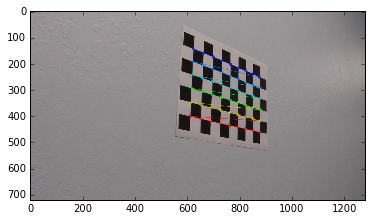

In [198]:
for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

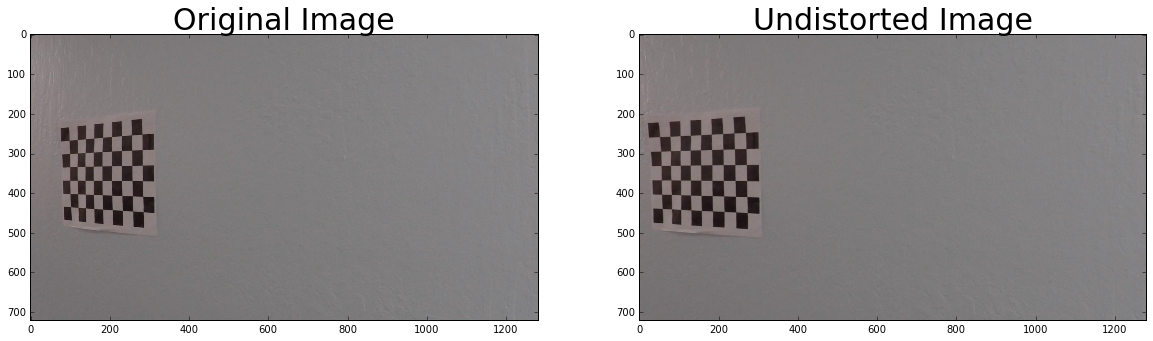

In [199]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [200]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

## II. Pipeline (Images)

## IIA. Initial runthrough of image pipeline

### II.2. Apply the distortion correction to the raw image.

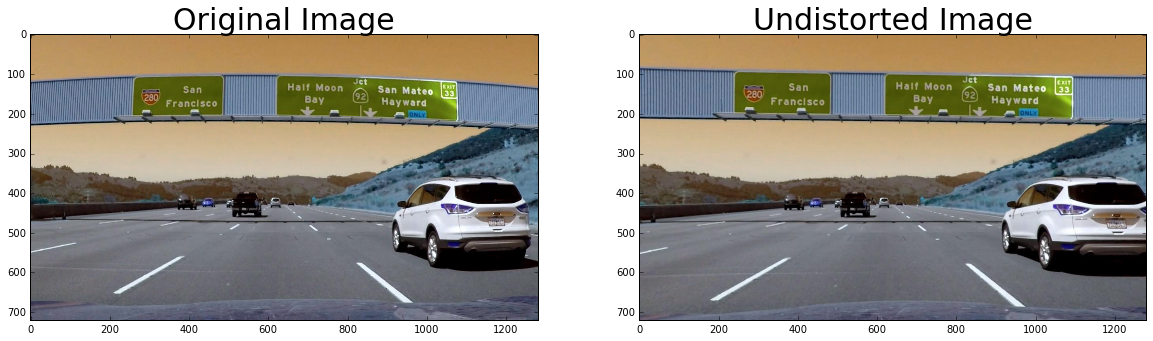

In [201]:
raw = cv2.imread("test_images/quiz.png")

corrected_raw = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(corrected_raw)
ax2.set_title('Undistorted Image', fontsize=30)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [202]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("Error: orient must be either x or y.")
    
    # 3) Take the absolute value of the derivative or gradient
    abs_derivative = np.absolute(derivative)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # So there are 1s where #s are within our thresholds and 0s otherwise.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 6) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 7) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary

In [203]:
def apply_thresholds(image, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))
    
    # Combine thresholds
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

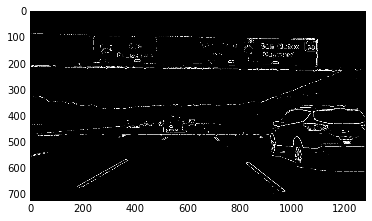

In [204]:
image = corrected_raw

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap="gray")

In [205]:
img = image

In [206]:
def apply_threshold_v2(image, xgrad_thresh=(20,100), s_thresh=(170,255)):
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    # Threshold colour channel

    # Convert to HLS colour space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Cont'd: Threshold colour channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

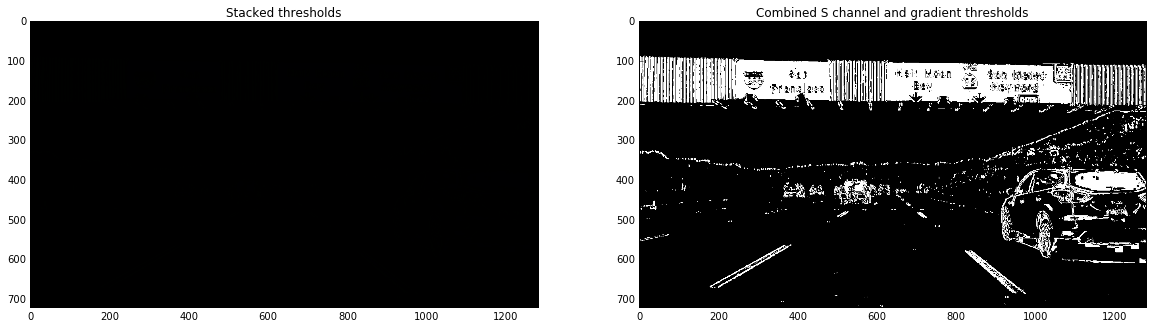

In [207]:


# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold colour channel

# Convert to HLS colour space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Cont'd: Threshold colour channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [208]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [209]:
imshape = combined_binary.shape
print(imshape)

(720, 1280)


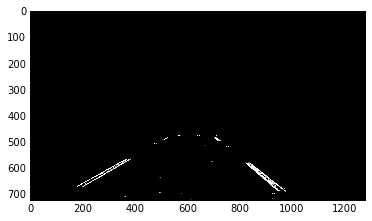

In [210]:
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

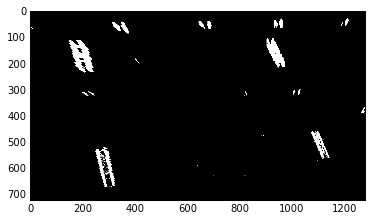

In [211]:
src = np.float32(
    [[0, 720],
     [550, 470],
     [700, 470],
     [720, 1280]])

dst = np.float32(
    [[200,720],
     [200,0],
     [900,0],
     [900,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

### 5. Detect lane pixels and fit to find lane boundary.

In [212]:
from scipy import signal

In [213]:
def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

# User used with x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

In [214]:
def histogram_pixels(warped_thresholded_image, offset=50, steps=6, 
                     window_radius=200, medianfilt_kernel_size=51):
    
    # Initialise arrays
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # Parameters
    height = warped_thresholded_image.shape[0]
    offset_height = height - offset
    half_frame = warped_thresholded_image.shape[1] // 2
    pixels_per_step = offset_height / steps
    
    for step in range(steps):
        # Printouts for debugging
        print("Step ", step)

        left_x_window_centres = []
        right_x_window_centres = []
        y_window_centres = []

        # Define the window (horizontal slice)
        window_start_y = height - (step * pixels_per_step) + offset 
        window_end_y = window_start_y - pixels_per_step + offset

        # Take a count of all the pixels at each x-value in the horizontal slice
        histogram = np.sum(warped_thresholded_image[window_end_y:window_start_y,:], axis=0)
        # plt.plot(histogram)

        # Smoothen the histogram
        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        # plt.plot(histogram_smooth)

        # Identify the left and right peaks
        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1,10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1,10)))
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centres.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centres.append(right_peak)

        # Add coordinates to window centres

        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centres.append((window_start_y + window_end_y) // 2)

        # Get pixels in the left window
        for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
            left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre, y_centre, window_radius)
            # plt.scatter(left_x_additional, left_y_additional)
            # Add pixels to list
            left_x.append(left_x_additional)
            left_y.append(left_y_additional)

        # Get pixels in the right window
        for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
            right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre, y_centre, window_radius)
            # plt.scatter(right_x_additional, right_y_additional)
            # Add pixels to list
            right_x.append(right_x_additional)
            right_y.append(right_y_additional)
        
    return collapse_into_single_arrays(leftx, lefty, rightx, righty)

In [215]:
def collapse_into_single_arrays(leftx, lefty, rightx, righty):
    leftx = [x 
            for array in left_x
            for x in array]
    lefty = [x 
            for array in left_y
            for x in array]
    rightx = [x 
            for array in right_x
            for x in array]
    righty = [x 
            for array in right_y
            for x in array]

    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)
    
    return leftx, lefty, rightx, righty

In [216]:
# Format coordinates

leftx = [x 
        for array in left_x
        for x in array]
lefty = [x 
        for array in left_y
        for x in array]
rightx = [x 
        for array in right_x
        for x in array]
righty = [x 
        for array in right_y
        for x in array]

leftx = np.array(leftx)
lefty = np.array(lefty)
rightx = np.array(rightx)
righty = np.array(righty)

In [217]:
def fit_second_order_poly(indep, dep):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    return fitdep

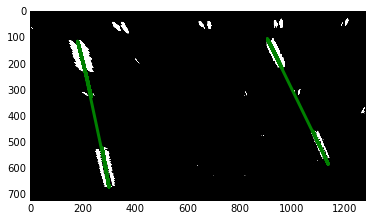

In [218]:
# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

plt.plot(left_fitx, lefty, color='green', linewidth=3)
plt.plot(right_fitx, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

Section reference: 
* https://github.com/pkern90/CarND-advancedLaneLines

### 6. Determine curvature of the lane and vehicle position with respect to center.

In [219]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(lefty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print("Left lane curve radius: ", left_curverad)
print("Right lane curve radius: ", right_curverad)
# Example values: 1163.9    1213.7

Left lane curve radius:  5576.07863137
Right lane curve radius:  16542.1163189


### 7. Warp the detected lane boundaries back onto the original image.

Note that the xs are a function of the ys, not the other way round.

In [220]:
# create an empty canvas
blank_canvas = np.zeros_like(gray)
print("Image shape: ", blank_canvas.shape)

Image shape:  (720, 1280)


In [221]:
def left_lane_poly(yval):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    return left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]

def right_lane_poly(yval):
    return right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]

In [222]:
def draw_poly(img, poly, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

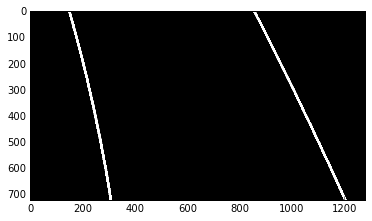

In [223]:
polyfit_left = draw_poly(blank_canvas, left_lane_poly, 30)
polyfit_drawn = draw_poly(polyfit_left, right_lane_poly, 30)
plt.imshow(polyfit_drawn, cmap="gray")

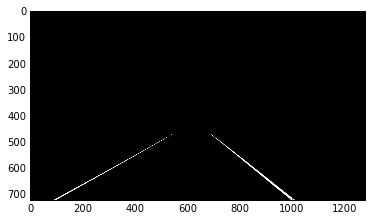

In [224]:
# warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(lane_lines, cmap="gray")

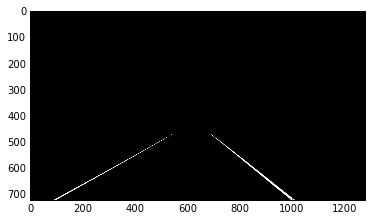

In [225]:
lane_line_colour = cv2.cvtColor(lane_lines, cv2.COLOR_GRAY2RGB)
plt.imshow(lane_line_colour)

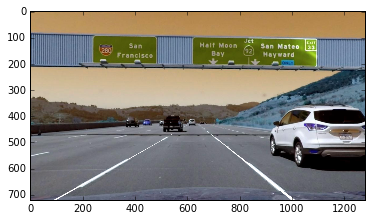

In [226]:
combined_img = cv2.add(lane_line_colour, corrected_raw)
plt.imshow(combined_img)

See `draw_poly()` in [file](https://github.com/pkern90/CarND-advancedLaneLines/blob/master/LaneDetection/ImageUtils.py).

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


Further references:
* https://github.com/mohankarthik/CarND-AdvancedLaneLines-P4
* https://github.com/pkern90/CarND-advancedLaneLines

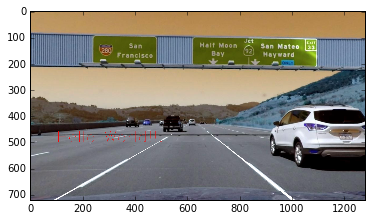

In [229]:
plt.imshow(cv2.putText(combined_img,"Hello World!!!", 
            (100,500), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))

## IIB: Streamlined image pipeline

Left lane curve radius:  2785.54731239
Right lane curve radius:  2419.52353806
Left coeffs:  [  2.01349380e-04   1.31217200e-02   3.68769578e+02]
Right fit:  [  4.50778156e-04   2.23567851e-01   1.05552442e+03]


array([[[200, 153,  97],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [197, 150,  88],
        [196, 149,  87],
        [194, 147,  85]],

       [[201, 154,  98],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [194, 147,  85]],

       [[201, 154,  98],
        [201, 154,  98],
        [201, 154,  98],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [195, 148,  86]],

       ..., 
       [[104,  89, 103],
        [104,  90, 104],
        [105,  91, 105],
        ..., 
        [100, 107, 126],
        [101, 108, 127],
        [ 97, 104, 123]],

       [[103,  91, 105],
        [104,  92, 106],
        [105,  92, 107],
        ..., 
        [ 99, 106, 125],
        [ 99, 106, 125],
        [ 97, 104, 123]],

       [[105,  94, 110],
        [105,  94, 110],
        [104,  94, 110],
        ..., 
        [100, 107, 126],
        [100, 107, 126],
        [100, 107,

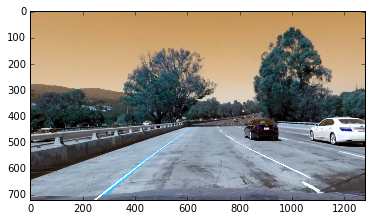

In [192]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

def image_pipeline(file, filepath=False):
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape

    src = np.float32(
        [[0, 720],
         [550, 470],
         [700, 470],
         [720, 1280]])

    dst = np.float32(
        [[200, 720],
         [200, 0],
         [900, 0],
         [900, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
    combined = apply_thresholds(image)

    ## Option II

    combined_binary = apply_threshold_v2(image, xgrad_thresh=(40,100), s_thresh=(150,255))
#    plt.imshow(combined_binary, cmap="gray")

    # Plotting thresholded images
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Option 1')
    ax1.imshow(combined, cmap="gray")

    ax2.set_title('Option 2: Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    """

    # Warp onto birds-eye-view
    # Previous region-of-interest mask's function is absorbed by the warp
    warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    plt.imshow(warped, cmap="gray")


    # Histogram and get pixels in window

    leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """
    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(lefty)
    left_curverad = ((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1]) ** 2) ** 1.5) \
                    / np.absolute(2 * left_coeffs[0])
    right_curverad = ((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     / np.absolute(2 * right_coeffs[0])
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)

    # TODO: Det vehicle position wrt centre

    ## 7. Warp the detected lane boundaries back onto the original image.

    # plt.imshow(blank_canvas, cmap="gray")
    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
#    plt.imshow(polyfit_left, cmap="gray")
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)
    lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(lane_lines, cmap="gray")

    # Convert to colour
    lane_line_colour = cv2.cvtColor(lane_lines.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    combined_img = cv2.add(lane_line_colour, image)
    plt.imshow(combined_img)
    return combined_img

image_pipeline("test_images/test1.jpg", filepath=True)

## III. Video Pipeline


In [190]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left lane curve radius:  2287.87558562
Right lane curve radius:  1371.62764263
Left coeffs:  [ -2.30620962e-04   4.96883183e-01   2.70057431e+02]
Right fit:  [ -4.08119268e-04   8.20821597e-01   9.14068960e+02]
[MoviePy] >>>> Building video project_output_2.mp4
[MoviePy] Writing video project_output_2.mp4


  0%|          | 1/376 [00:00<02:28,  2.52it/s]

Left lane curve radius:  2287.87558562
Right lane curve radius:  1371.62764263
Left coeffs:  [ -2.30620962e-04   4.96883183e-01   2.70057431e+02]
Right fit:  [ -4.08119268e-04   8.20821597e-01   9.14068960e+02]


  1%|          | 2/376 [00:00<02:27,  2.53it/s]

Left lane curve radius:  2320.62106774
Right lane curve radius:  3442.80887867
Left coeffs:  [ -2.27919692e-04   4.97647448e-01   2.71104458e+02]
Right fit:  [  2.47701110e-04   3.25394376e-01   1.00815077e+03]


  1%|          | 3/376 [00:01<02:25,  2.56it/s]

Left lane curve radius:  2219.16771661
Right lane curve radius:  6118.74697265
Left coeffs:  [ -2.37899496e-04   5.07107173e-01   2.68039389e+02]
Right fit:  [  1.24649494e-04   4.05157369e-01   9.98645532e+02]


  1%|          | 4/376 [00:01<02:26,  2.53it/s]

Left lane curve radius:  2274.02706099
Right lane curve radius:  3226.9777842
Left coeffs:  [ -2.32878055e-04   5.06405089e-01   2.71616106e+02]
Right fit:  [ -2.07588597e-04   7.39275270e-01   9.13914367e+02]


  1%|▏         | 5/376 [00:01<02:28,  2.50it/s]

Left lane curve radius:  1911.07609812
Right lane curve radius:  2930.40341864
Left coeffs:  [ -2.72459844e-04   5.37715026e-01   2.64125724e+02]
Right fit:  [ -2.22055722e-04   7.41516591e-01   9.16245561e+02]


  2%|▏         | 6/376 [00:02<02:28,  2.50it/s]

Left lane curve radius:  2178.7874972
Right lane curve radius:  3535.68557725
Left coeffs:  [ -2.43142865e-04   5.19657062e-01   2.67089797e+02]
Right fit:  [ -1.91496025e-04   7.26426799e-01   9.16523265e+02]


  2%|▏         | 7/376 [00:02<02:28,  2.49it/s]

Left lane curve radius:  2081.11576419
Right lane curve radius:  3162.50508002
Left coeffs:  [ -2.53966565e-04   5.30396322e-01   2.67110326e+02]
Right fit:  [  1.01342426e-03   2.23683442e-01   9.65870740e+02]


  2%|▏         | 8/376 [00:03<02:26,  2.51it/s]

Left lane curve radius:  2268.23600575
Right lane curve radius:  766.00280269
Left coeffs:  [ -2.34933588e-04   5.19329137e-01   2.67982829e+02]
Right fit:  [ -6.54531869e-04   9.09380539e-01   9.00488700e+02]


  2%|▏         | 9/376 [00:03<02:25,  2.52it/s]

Left lane curve radius:  2721.70064099
Right lane curve radius:  3227.14347516
Left coeffs:  [ -1.98624739e-04   4.93714305e-01   2.72914836e+02]
Right fit:  [ -2.03831734e-04   7.17395879e-01   9.20750076e+02]


  3%|▎         | 10/376 [00:03<02:24,  2.53it/s]

Left lane curve radius:  2978.20564502
Right lane curve radius:  2500.1031814
Left coeffs:  [ -1.82802125e-04   4.83295649e-01   2.74774586e+02]
Right fit:  [  7.33865827e-04   2.04157789e-01   9.92754946e+02]


  3%|▎         | 11/376 [00:04<02:25,  2.51it/s]

Left lane curve radius:  3311.45984106
Right lane curve radius:  2249.2306638
Left coeffs:  [ -1.65377385e-04   4.68733919e-01   2.77279020e+02]
Right fit:  [  9.24782133e-04   3.70561241e-02   1.02807636e+03]


  3%|▎         | 12/376 [00:04<02:30,  2.42it/s]

Left lane curve radius:  3405.26004153
Right lane curve radius:  4818.96042823
Left coeffs:  [ -1.61765225e-04   4.72123405e-01   2.72593390e+02]
Right fit:  [ -1.41825417e-04   6.68806210e-01   9.38570215e+02]


  3%|▎         | 13/376 [00:05<02:31,  2.40it/s]

Left lane curve radius:  3132.8939035
Right lane curve radius:  2782.90365575
Left coeffs:  [ -1.75044816e-04   4.83461866e-01   2.68270368e+02]
Right fit:  [ -2.29274064e-04   7.23209026e-01   9.33970994e+02]


  4%|▎         | 14/376 [00:05<02:28,  2.44it/s]

Left lane curve radius:  3033.7207579
Right lane curve radius:  4817.10579318
Left coeffs:  [ -1.80144851e-04   4.85672796e-01   2.67996927e+02]
Right fit:  [  1.77990258e-04   4.22106024e-01   9.90091655e+02]


  4%|▍         | 15/376 [00:06<02:26,  2.46it/s]

Left lane curve radius:  3215.306105
Right lane curve radius:  3550.07381759
Left coeffs:  [ -1.70563833e-04   4.77925536e-01   2.64731331e+02]
Right fit:  [ -1.86531849e-04   7.00839199e-01   9.39743261e+02]


  4%|▍         | 16/376 [00:06<02:24,  2.49it/s]

Left lane curve radius:  5336.4409516
Right lane curve radius:  8904.33164905
Left coeffs:  [ -1.05875616e-04   4.31535615e-01   2.72435538e+02]
Right fit:  [ -7.87136836e-05   6.06739314e-01   9.59407478e+02]


  5%|▍         | 17/376 [00:06<02:25,  2.46it/s]

Left lane curve radius:  5159.79563739
Right lane curve radius:  7810.03355284
Left coeffs:  [ -1.09087948e-04   4.31074056e-01   2.72129332e+02]
Right fit:  [ -9.29874951e-05   6.54662336e-01   9.39870034e+02]


  5%|▍         | 18/376 [00:07<02:24,  2.48it/s]

Left lane curve radius:  3917.686615
Right lane curve radius:  4983.81048569
Left coeffs:  [ -1.40591502e-04   4.44264890e-01   2.74473305e+02]
Right fit:  [  1.71602823e-03   1.02554825e-01   9.76512432e+02]


  5%|▌         | 19/376 [00:07<02:23,  2.49it/s]

Left lane curve radius:  3417.68621008
Right lane curve radius:  2202.59368652
Left coeffs:  [ -1.59579709e-04   4.55504332e-01   2.72534646e+02]
Right fit:  [ -2.64214196e-04   6.76145812e-01   9.36322110e+02]


  5%|▌         | 20/376 [00:08<02:22,  2.50it/s]

Left lane curve radius:  3215.04860883
Right lane curve radius:  3166.88609436
Left coeffs:  [ -1.68922781e-04   4.61697124e-01   2.70967660e+02]
Right fit:  [  1.18058857e-03   1.17349239e-01   9.91658470e+02]


  6%|▌         | 21/376 [00:08<02:22,  2.49it/s]

Left lane curve radius:  2721.05443994
Right lane curve radius:  1311.91306868
Left coeffs:  [ -1.96949037e-04   4.78693393e-01   2.70932562e+02]
Right fit:  [ -4.17765355e-04   8.05174452e-01   9.17434805e+02]


  6%|▌         | 22/376 [00:08<02:22,  2.48it/s]

Left lane curve radius:  2625.30396712
Right lane curve radius:  4155.91570301
Left coeffs:  [ -2.03816884e-04   4.85306404e-01   2.69183225e+02]
Right fit:  [ -1.59399468e-04   6.65567517e-01   9.38461513e+02]


  6%|▌         | 23/376 [00:09<02:22,  2.47it/s]

Left lane curve radius:  2588.3238353
Right lane curve radius:  2797.24770995
Left coeffs:  [ -2.05947550e-04   4.81908434e-01   2.76272923e+02]
Right fit:  [  4.85187218e-04   3.29199524e-01   9.76129286e+02]


  6%|▋         | 24/376 [00:09<02:20,  2.50it/s]

Left lane curve radius:  2597.46199233
Right lane curve radius:  704.122216544
Left coeffs:  [ -2.05435020e-04   4.82942496e-01   2.75868626e+02]
Right fit:  [ -7.22424069e-04   1.06532733e+00   8.65244671e+02]


  7%|▋         | 25/376 [00:10<02:19,  2.52it/s]

Left lane curve radius:  2989.52189164
Right lane curve radius:  1392.94048294
Left coeffs:  [ -1.80432003e-04   4.67010497e-01   2.75778128e+02]
Right fit:  [ -4.13048019e-04   8.60911575e-01   9.01477668e+02]


  7%|▋         | 26/376 [00:10<02:20,  2.50it/s]

Left lane curve radius:  3177.7730265
Right lane curve radius:  4487.78745246
Left coeffs:  [ -1.70913080e-04   4.64408616e-01   2.73886177e+02]
Right fit:  [ -1.53086032e-04   6.88425896e-01   9.30477754e+02]


  7%|▋         | 27/376 [00:10<02:19,  2.50it/s]

Left lane curve radius:  3373.04007629
Right lane curve radius:  3101.01983939
Left coeffs:  [ -1.61466970e-04   4.55981994e-01   2.72009032e+02]
Right fit:  [  3.07498666e-04   3.26265303e-01   1.00189455e+03]


  7%|▋         | 28/376 [00:11<02:21,  2.46it/s]

Left lane curve radius:  3774.66422103
Right lane curve radius:  6012.21884605
Left coeffs:  [ -1.45036792e-04   4.41969851e-01   2.76130429e+02]
Right fit:  [ -1.17711093e-04   6.66605604e-01   9.30941929e+02]


  8%|▊         | 29/376 [00:11<02:20,  2.48it/s]

Left lane curve radius:  5233.71908566
Right lane curve radius:  9453.09741573
Left coeffs:  [ -1.06925676e-04   4.21051263e-01   2.74083083e+02]
Right fit:  [ -7.64881268e-05   6.29427649e-01   9.41755948e+02]


  8%|▊         | 30/376 [00:12<02:18,  2.50it/s]

Left lane curve radius:  6560.22077727
Right lane curve radius:  13293.9522629
Left coeffs:  [ -8.61527799e-05   4.06167336e-01   2.72922180e+02]
Right fit:  [ -5.48181180e-05   6.07120665e-01   9.47564637e+02]


  8%|▊         | 31/376 [00:12<02:23,  2.41it/s]

Left lane curve radius:  5932.46481062
Right lane curve radius:  9871.69979574
Left coeffs:  [ -9.47732441e-05   4.10892862e-01   2.71422746e+02]
Right fit:  [ -7.23239579e-05   6.13636181e-01   9.47035649e+02]


  9%|▊         | 32/376 [00:12<02:21,  2.44it/s]

Left lane curve radius:  5981.19638158
Right lane curve radius:  1289.2848814
Left coeffs:  [ -9.39505745e-05   4.09122099e-01   2.70440598e+02]
Right fit:  [ -4.14307467e-04   7.61606596e-01   9.31107295e+02]


  9%|▉         | 33/376 [00:13<02:23,  2.39it/s]

Left lane curve radius:  5733.30905281
Right lane curve radius:  3428.10996839
Left coeffs:  [ -9.71388959e-05   4.02004381e-01   2.75098573e+02]
Right fit:  [ -1.91835064e-04   7.02466435e-01   9.27200060e+02]


  9%|▉         | 34/376 [00:13<02:23,  2.38it/s]

Left lane curve radius:  5374.8755631
Right lane curve radius:  1233.42650109
Left coeffs:  [ -1.03396847e-04   4.07514792e-01   2.70586361e+02]
Right fit:  [ -4.35788513e-04   8.01015284e-01   9.19765355e+02]


  9%|▉         | 35/376 [00:14<02:22,  2.39it/s]

Left lane curve radius:  3716.08871347
Right lane curve radius:  2149.2272351
Left coeffs:  [ -1.46476393e-04   4.35875362e-01   2.67197109e+02]
Right fit:  [ -2.78051659e-04   7.24534366e-01   9.25745352e+02]


 10%|▉         | 36/376 [00:14<02:30,  2.25it/s]

Left lane curve radius:  3818.04103302
Right lane curve radius:  4780.46072334
Left coeffs:  [ -1.43258754e-04   4.38893004e-01   2.61491061e+02]
Right fit:  [  1.96185373e-04   4.60832359e-01   9.66830864e+02]


 10%|▉         | 37/376 [00:15<02:28,  2.28it/s]

Left lane curve radius:  3263.47609058
Right lane curve radius:  1788.17715602
Left coeffs:  [ -1.66319689e-04   4.58389723e-01   2.55643727e+02]
Right fit:  [ -3.30849096e-04   7.84558046e-01   9.17975236e+02]


 10%|█         | 38/376 [00:15<02:29,  2.27it/s]

Left lane curve radius:  2992.97542439
Right lane curve radius:  913.321982204
Left coeffs:  [ -1.81098450e-04   4.75965247e-01   2.49343537e+02]
Right fit:  [ -5.77693995e-04   9.59373584e-01   8.90012212e+02]


 10%|█         | 39/376 [00:15<02:25,  2.32it/s]

Left lane curve radius:  2833.29358346
Right lane curve radius:  4145.9779701
Left coeffs:  [ -1.90234138e-04   4.79958257e-01   2.50827961e+02]
Right fit:  [ -1.63098613e-04   6.89411638e-01   9.30186326e+02]


 11%|█         | 40/376 [00:16<02:25,  2.31it/s]

Left lane curve radius:  2333.68182623
Right lane curve radius:  6042.54675468
Left coeffs:  [ -2.27136813e-04   5.01783217e-01   2.49968202e+02]
Right fit:  [ -1.17540668e-04   6.70028928e-01   9.26094401e+02]


 11%|█         | 41/376 [00:16<02:27,  2.28it/s]

Left lane curve radius:  2944.5602594
Right lane curve radius:  890.836377098
Left coeffs:  [ -1.84019678e-04   4.79391291e-01   2.49830596e+02]
Right fit:  [ -6.27605924e-04   1.11277434e+00   8.30006321e+02]


 11%|█         | 42/376 [00:17<02:31,  2.21it/s]

Left lane curve radius:  2355.40460345
Right lane curve radius:  31790.1709779
Left coeffs:  [ -2.24389125e-04   5.01535294e-01   2.49244388e+02]
Right fit:  [ -2.51846952e-05   6.41704834e-01   9.16096907e+02]


 11%|█▏        | 43/376 [00:17<02:27,  2.25it/s]

Left lane curve radius:  2821.86598592
Right lane curve radius:  23926.2499483
Left coeffs:  [ -1.91985055e-04   4.90089853e-01   2.44229877e+02]
Right fit:  [  3.43336994e-05   5.80650434e-01   9.32118547e+02]


 12%|█▏        | 44/376 [00:18<02:24,  2.29it/s]

Left lane curve radius:  2659.45243227
Right lane curve radius:  6418.48394021
Left coeffs:  [ -2.03371554e-04   5.02752468e-01   2.38773259e+02]
Right fit:  [  1.37868421e-04   4.96900574e-01   9.47093404e+02]


 12%|█▏        | 45/376 [00:18<02:25,  2.27it/s]

Left lane curve radius:  2613.26504452
Right lane curve radius:  2881.57357485
Left coeffs:  [ -2.07384566e-04   5.11555454e-01   2.31678079e+02]
Right fit:  [  1.11604585e-03   7.91723543e-02   9.96673198e+02]


 12%|█▏        | 46/376 [00:19<02:24,  2.29it/s]

Left lane curve radius:  2654.87453866
Right lane curve radius:  2875.78884645
Left coeffs:  [ -2.04948716e-04   5.14202115e-01   2.28010013e+02]
Right fit:  [  4.43446817e-04   3.39434950e-01   9.74186989e+02]


 12%|█▎        | 47/376 [00:19<02:25,  2.26it/s]

Left lane curve radius:  2958.72816528
Right lane curve radius:  4872.34169005
Left coeffs:  [ -1.85134884e-04   4.97763657e-01   2.29565205e+02]
Right fit:  [ -1.36156965e-04   6.37380353e-01   9.36414134e+02]


 13%|█▎        | 48/376 [00:19<02:26,  2.24it/s]

Left lane curve radius:  3005.418282
Right lane curve radius:  2265.10966623
Left coeffs:  [ -1.82296219e-04   4.94261791e-01   2.29745330e+02]
Right fit:  [  1.13661544e-03  -1.10729634e-01   1.04298019e+03]


 13%|█▎        | 49/376 [00:20<02:24,  2.26it/s]

Left lane curve radius:  2713.18999178
Right lane curve radius:  73632.8319641
Left coeffs:  [ -2.00343967e-04   5.06996845e-01   2.29634998e+02]
Right fit:  [ -9.97680073e-06   5.54064421e-01   9.43798128e+02]


 13%|█▎        | 50/376 [00:20<02:24,  2.26it/s]

Left lane curve radius:  2882.8580142
Right lane curve radius:  1624.39574145
Left coeffs:  [ -1.88879940e-04   4.94220711e-01   2.32685824e+02]
Right fit:  [ -3.55863545e-04   7.94100194e-01   9.02093639e+02]


 14%|█▎        | 51/376 [00:21<02:21,  2.29it/s]

Left lane curve radius:  3050.36201288
Right lane curve radius:  3387.96896255
Left coeffs:  [ -1.79353831e-04   4.87945696e-01   2.32705612e+02]
Right fit:  [  2.70667539e-04   3.44845273e-01   9.82765832e+02]


 14%|█▍        | 52/376 [00:21<02:25,  2.22it/s]

Left lane curve radius:  3422.71918173
Right lane curve radius:  6415.47266398
Left coeffs:  [ -1.61620059e-04   4.79942955e-01   2.27931549e+02]
Right fit:  [  1.21490243e-04   4.24557899e-01   9.78332117e+02]


 14%|█▍        | 53/376 [00:22<02:25,  2.23it/s]

Left lane curve radius:  5718.22341971
Right lane curve radius:  3337.74116068
Left coeffs:  [ -9.97091571e-05   4.35674931e-01   2.33533936e+02]
Right fit:  [ -1.91374894e-04   6.76826099e-01   9.30751353e+02]


 14%|█▍        | 54/376 [00:22<02:26,  2.20it/s]

Left lane curve radius:  9762.16288104
Right lane curve radius:  3117.90354856
Left coeffs:  [ -5.92796275e-05   3.99125403e-01   2.40440752e+02]
Right fit:  [ -2.06909787e-04   7.06751087e-01   9.23227687e+02]


 15%|█▍        | 55/376 [00:23<02:26,  2.20it/s]

Left lane curve radius:  11262.0548124
Right lane curve radius:  3955.3902362
Left coeffs:  [ -5.12696065e-05   3.85839920e-01   2.43031675e+02]
Right fit:  [ -1.66163714e-04   6.69174654e-01   9.34962065e+02]


 15%|█▍        | 56/376 [00:23<02:25,  2.20it/s]

Left lane curve radius:  10168.8486278
Right lane curve radius:  2944.9124779
Left coeffs:  [ -5.60526851e-05   3.77107400e-01   2.49892790e+02]
Right fit:  [ -2.16682325e-04   7.10121604e-01   9.27118893e+02]


 15%|█▌        | 57/376 [00:24<02:22,  2.23it/s]

Left lane curve radius:  16562.3141532
Right lane curve radius:  119198.812301
Left coeffs:  [ -3.45982354e-05   3.54741528e-01   2.52711254e+02]
Right fit:  [ -6.72930867e-06   6.17611107e-01   9.41488086e+02]


 15%|█▌        | 58/376 [00:24<02:25,  2.19it/s]

Left lane curve radius:  8830.16289418
Right lane curve radius:  589.173832493
Left coeffs:  [ -6.32566898e-05   3.61601496e-01   2.58554837e+02]
Right fit:  [ -8.75339147e-04   1.02852174e+00   8.90383974e+02]


 16%|█▌        | 59/376 [00:25<02:34,  2.05it/s]

Left lane curve radius:  6729.06923685
Right lane curve radius:  6271.80244749
Left coeffs:  [ -8.17522792e-05   3.65808079e-01   2.62817935e+02]
Right fit:  [  1.55611824e-04   5.41367479e-01   9.43740244e+02]


 16%|█▌        | 60/376 [00:25<02:28,  2.12it/s]

Left lane curve radius:  4344.87513232
Right lane curve radius:  81839.6248692
Left coeffs:  [ -1.23695079e-04   3.87577070e-01   2.64543442e+02]
Right fit:  [ -9.74185961e-06   6.17076812e-01   9.33333378e+02]


 16%|█▌        | 61/376 [00:25<02:21,  2.22it/s]

Left lane curve radius:  2335.9608254
Right lane curve radius:  2207.57178003
Left coeffs:  [ -2.21788272e-04   4.51591829e-01   2.63862873e+02]
Right fit:  [ -2.89009233e-04   8.06745994e-01   8.94918286e+02]


 16%|█▋        | 62/376 [00:26<02:16,  2.31it/s]

Left lane curve radius:  2077.2743134
Right lane curve radius:  640.328109848
Left coeffs:  [ -2.47560669e-04   4.68759804e-01   2.62825867e+02]
Right fit:  [ -7.90876995e-04   1.15062074e+00   8.36874355e+02]


 17%|█▋        | 63/376 [00:26<02:12,  2.35it/s]

Left lane curve radius:  1691.66756615
Right lane curve radius:  1049.84019795
Left coeffs:  [ -3.00925550e-04   5.12418852e-01   2.59513099e+02]
Right fit:  [ -5.34396822e-04   9.97517976e-01   8.57244646e+02]


 17%|█▋        | 64/376 [00:27<02:10,  2.39it/s]

Left lane curve radius:  1509.99404484
Right lane curve radius:  2135.50502686
Left coeffs:  [ -3.35282652e-04   5.39310531e-01   2.56558025e+02]
Right fit:  [ -3.03577361e-04   8.40377738e-01   8.83721745e+02]


 17%|█▋        | 65/376 [00:27<02:09,  2.41it/s]

Left lane curve radius:  1551.05303354
Right lane curve radius:  4889.38604251
Left coeffs:  [ -3.28054149e-04   5.46623001e-01   2.55167783e+02]
Right fit:  [ -1.56211013e-04   7.79984040e-01   8.82190981e+02]


 18%|█▊        | 66/376 [00:27<02:04,  2.48it/s]

Left lane curve radius:  1697.08252574
Right lane curve radius:  3455.53846447
Left coeffs:  [ -3.01916890e-04   5.31565807e-01   2.60341808e+02]
Right fit:  [ -2.09018864e-04   8.06385191e-01   8.78115588e+02]


 18%|█▊        | 67/376 [00:28<02:10,  2.36it/s]

Left lane curve radius:  1805.91706002
Right lane curve radius:  3834.34781857
Left coeffs:  [ -2.86057703e-04   5.29951909e-01   2.57846977e+02]
Right fit:  [ -1.89221140e-04   7.83196646e-01   8.85158540e+02]


 18%|█▊        | 68/376 [00:28<02:10,  2.37it/s]

Left lane curve radius:  1887.46006798
Right lane curve radius:  8645.18552059
Left coeffs:  [ -2.75291376e-04   5.27832304e-01   2.60425775e+02]
Right fit:  [ -9.16509796e-05   7.21440571e-01   8.90751318e+02]


 18%|█▊        | 69/376 [00:29<02:12,  2.31it/s]

Left lane curve radius:  2209.43001398
Right lane curve radius:  3080.11193448
Left coeffs:  [ -2.38599633e-04   5.06824172e-01   2.62708640e+02]
Right fit:  [ -2.28365062e-04   8.09197671e-01   8.80721939e+02]


 19%|█▊        | 70/376 [00:29<02:10,  2.34it/s]

Left lane curve radius:  2268.05867374
Right lane curve radius:  2465.28601753
Left coeffs:  [ -2.33259381e-04   5.05631553e-01   2.62031463e+02]
Right fit:  [ -2.65995328e-04   7.98391578e-01   8.86291007e+02]


 19%|█▉        | 71/376 [00:30<02:14,  2.27it/s]

Left lane curve radius:  2506.78693964
Right lane curve radius:  2410.34170735
Left coeffs:  [ -2.13966124e-04   5.03054281e-01   2.52510087e+02]
Right fit:  [ -2.59934832e-04   7.48048755e-01   9.08959671e+02]


 19%|█▉        | 72/376 [00:30<02:15,  2.24it/s]

Left lane curve radius:  2729.95567017
Right lane curve radius:  2585.79151847
Left coeffs:  [ -1.98751677e-04   5.01382185e-01   2.43193990e+02]
Right fit:  [  6.95767725e-04   2.34334498e-01   9.87347031e+02]


 19%|█▉        | 73/376 [00:31<02:17,  2.21it/s]

Left lane curve radius:  2929.43943114
Right lane curve radius:  2309.39395324
Left coeffs:  [ -1.87310156e-04   5.02361175e-01   2.32837134e+02]
Right fit:  [  9.86706817e-04   8.13083016e-03   1.03574448e+03]


 20%|█▉        | 74/376 [00:31<02:13,  2.26it/s]

Left lane curve radius:  3092.89729444
Right lane curve radius:  2493.75877717
Left coeffs:  [ -1.79064912e-04   5.04471340e-01   2.23512158e+02]
Right fit:  [  4.91521218e-04   2.48799589e-01   1.01520851e+03]


 20%|█▉        | 75/376 [00:31<02:11,  2.29it/s]

Left lane curve radius:  2784.35703815
Right lane curve radius:  3425.71005971
Left coeffs:  [ -1.97416224e-04   5.19062240e-01   2.20441242e+02]
Right fit:  [  2.83386721e-04   3.67282775e-01   9.97098040e+02]


 20%|██        | 76/376 [00:32<02:10,  2.30it/s]

Left lane curve radius:  2748.95103138
Right lane curve radius:  3157.17511789
Left coeffs:  [ -2.00501013e-04   5.26924654e-01   2.14942767e+02]
Right fit:  [  2.95662003e-04   3.23449063e-01   1.01164530e+03]


 20%|██        | 77/376 [00:32<02:06,  2.36it/s]

Left lane curve radius:  2278.47212469
Right lane curve radius:  9927.21505923
Left coeffs:  [ -2.36272975e-04   5.40360072e-01   2.15914483e+02]
Right fit:  [  7.89819897e-05   4.85886334e-01   9.77499799e+02]


 21%|██        | 78/376 [00:33<02:06,  2.35it/s]

Left lane curve radius:  2797.03539647
Right lane curve radius:  3321.87702703
Left coeffs:  [ -1.95447825e-04   5.09102665e-01   2.22499216e+02]
Right fit:  [  2.61764308e-04   3.17710551e-01   1.01259944e+03]


 21%|██        | 79/376 [00:33<02:07,  2.32it/s]

Left lane curve radius:  2150.51186117
Right lane curve radius:  4713.86036524
Left coeffs:  [ -2.47283578e-04   5.44572114e-01   2.15791306e+02]
Right fit:  [ -1.45547713e-04   6.84577784e-01   9.29351437e+02]


 21%|██▏       | 80/376 [00:34<02:12,  2.23it/s]

Left lane curve radius:  2805.71899156
Right lane curve radius:  9723.21568501
Left coeffs:  [ -1.93949556e-04   5.00452555e-01   2.26583945e+02]
Right fit:  [ -7.59351770e-05   6.46346247e-01   9.28153888e+02]


 22%|██▏       | 81/376 [00:34<02:19,  2.12it/s]

Left lane curve radius:  2955.32888077
Right lane curve radius:  9472.26359005
Left coeffs:  [ -1.84449197e-04   4.90255926e-01   2.30658720e+02]
Right fit:  [ -7.76175230e-05   6.45230888e-01   9.27801964e+02]


 22%|██▏       | 82/376 [00:34<02:13,  2.21it/s]

Left lane curve radius:  3234.12352405
Right lane curve radius:  5904.56929423
Left coeffs:  [ -1.68417282e-04   4.67669714e-01   2.42470695e+02]
Right fit:  [  1.75156149e-04   5.55206268e-01   9.28567894e+02]


 22%|██▏       | 83/376 [00:35<02:07,  2.30it/s]

Left lane curve radius:  3451.59954593
Right lane curve radius:  995.994022095
Left coeffs:  [ -1.57974866e-04   4.54937139e-01   2.48188255e+02]
Right fit:  [ -5.27112092e-04   8.86051896e-01   8.87466995e+02]


 22%|██▏       | 84/376 [00:35<02:03,  2.37it/s]

Left lane curve radius:  4122.23191749
Right lane curve radius:  4335.91129018
Left coeffs:  [ -1.33982278e-04   4.40875686e-01   2.47870176e+02]
Right fit:  [  2.58570346e-04   4.99025902e-01   9.39129263e+02]


 23%|██▎       | 85/376 [00:36<01:59,  2.44it/s]

Left lane curve radius:  3963.93913171
Right lane curve radius:  2496.91432168
Left coeffs:  [ -1.39312595e-04   4.47801442e-01   2.44166698e+02]
Right fit:  [  8.19305230e-04   1.53651827e-01   9.94350497e+02]


 23%|██▎       | 86/376 [00:36<01:57,  2.46it/s]

Left lane curve radius:  4024.83433458
Right lane curve radius:  2458.50476985
Left coeffs:  [ -1.37823294e-04   4.51872167e-01   2.38567841e+02]
Right fit:  [  6.25403281e-04   2.20236399e-01   9.97857393e+02]


 23%|██▎       | 87/376 [00:36<01:58,  2.44it/s]

Left lane curve radius:  3415.12460777
Right lane curve radius:  1211.15742125
Left coeffs:  [ -1.60758314e-04   4.68392324e-01   2.37339539e+02]
Right fit:  [ -4.61051603e-04   8.92428998e-01   8.93090562e+02]


 23%|██▎       | 88/376 [00:37<02:01,  2.38it/s]

Left lane curve radius:  3288.96040292
Right lane curve radius:  1490.80091766
Left coeffs:  [ -1.66444942e-04   4.71932454e-01   2.36321345e+02]
Right fit:  [ -3.94488150e-04   8.65069445e-01   8.94189869e+02]


 24%|██▎       | 89/376 [00:37<01:59,  2.41it/s]

Left lane curve radius:  2580.67430553
Right lane curve radius:  4052.97135827
Left coeffs:  [ -2.07660727e-04   4.94960678e-01   2.34219042e+02]
Right fit:  [  2.23074994e-04   3.97842450e-01   9.80045656e+02]


 24%|██▍       | 90/376 [00:38<02:00,  2.37it/s]

Left lane curve radius:  2579.15463934
Right lane curve radius:  4852.42172727
Left coeffs:  [ -2.08206914e-04   4.98938636e-01   2.32712794e+02]
Right fit:  [  1.75385676e-04   4.18041723e-01   9.76650536e+02]


 24%|██▍       | 91/376 [00:38<02:01,  2.34it/s]

Left lane curve radius:  2109.26681504
Right lane curve radius:  4396.08012479
Left coeffs:  [ -2.49708816e-04   5.30466818e-01   2.26606607e+02]
Right fit:  [ -1.59866917e-04   7.24100147e-01   9.04876920e+02]


 24%|██▍       | 92/376 [00:39<02:01,  2.35it/s]

Left lane curve radius:  1871.22926416
Right lane curve radius:  4578.93345684
Left coeffs:  [ -2.80258502e-04   5.54738309e-01   2.22064270e+02]
Right fit:  [ -1.55302659e-04   7.22269792e-01   9.02021789e+02]


 25%|██▍       | 93/376 [00:39<01:59,  2.36it/s]

Left lane curve radius:  1859.09560408
Right lane curve radius:  4414.82748898
Left coeffs:  [ -2.83086567e-04   5.65174097e-01   2.14886094e+02]
Right fit:  [ -1.58086490e-04   7.10508796e-01   9.08052195e+02]


 25%|██▌       | 94/376 [00:39<02:00,  2.35it/s]

Left lane curve radius:  1880.39665302
Right lane curve radius:  8073.73251435
Left coeffs:  [ -2.80217269e-04   5.64113033e-01   2.16819168e+02]
Right fit:  [ -9.21821111e-05   6.74585721e-01   9.05714342e+02]


 25%|██▌       | 95/376 [00:40<02:00,  2.33it/s]

Left lane curve radius:  2221.80661251
Right lane curve radius:  2163.69072207
Left coeffs:  [ -2.41586251e-04   5.43791209e-01   2.13812293e+02]
Right fit:  [ -2.81915774e-04   7.54236276e-01   9.01768203e+02]


 26%|██▌       | 96/376 [00:40<01:59,  2.33it/s]

Left lane curve radius:  2342.58542115
Right lane curve radius:  3947.97740176
Left coeffs:  [ -2.31054097e-04   5.42611073e-01   2.11600637e+02]
Right fit:  [ -1.76233363e-04   7.32552415e-01   9.00423993e+02]


 26%|██▌       | 97/376 [00:41<01:56,  2.39it/s]

Left lane curve radius:  2302.22486102
Right lane curve radius:  3456.80171944
Left coeffs:  [ -2.35453070e-04   5.50258357e-01   2.09068064e+02]
Right fit:  [  3.77400504e-04   4.41225685e-01   9.37555565e+02]


 26%|██▌       | 98/376 [00:41<01:54,  2.42it/s]

Left lane curve radius:  2762.52580707
Right lane curve radius:  1416.5734638
Left coeffs:  [ -1.99362433e-04   5.24744664e-01   2.10996234e+02]
Right fit:  [ -4.12103410e-04   8.81231150e-01   8.76832079e+02]


 26%|██▋       | 99/376 [00:42<01:51,  2.48it/s]

Left lane curve radius:  2524.09799106
Right lane curve radius:  1189.76149385
Left coeffs:  [ -2.15864436e-04   5.31636624e-01   2.14727298e+02]
Right fit:  [ -4.88467520e-04   9.78344457e-01   8.46990744e+02]


 27%|██▋       | 100/376 [00:42<01:51,  2.48it/s]

Left lane curve radius:  2599.11639912
Right lane curve radius:  4130.85752825
Left coeffs:  [ -2.10835397e-04   5.33093674e-01   2.10876244e+02]
Right fit:  [ -1.71790623e-04   7.42624273e-01   8.90573784e+02]


 27%|██▋       | 101/376 [00:42<01:50,  2.48it/s]

Left lane curve radius:  2376.84135606
Right lane curve radius:  2600.98776293
Left coeffs:  [ -2.27405450e-04   5.35146696e-01   2.14037581e+02]
Right fit:  [ -2.60615338e-04   8.22973895e-01   8.68412977e+02]


 27%|██▋       | 102/376 [00:43<01:52,  2.44it/s]

Left lane curve radius:  2655.33135865
Right lane curve radius:  2610.48850857
Left coeffs:  [ -2.06383355e-04   5.27215287e-01   2.11193414e+02]
Right fit:  [ -2.61649139e-04   8.30876280e-01   8.63859692e+02]


 27%|██▋       | 103/376 [00:43<01:54,  2.38it/s]

Left lane curve radius:  2814.5013363
Right lane curve radius:  22204.3339471
Left coeffs:  [ -1.95783614e-04   5.21070738e-01   2.08463716e+02]
Right fit:  [ -3.55182995e-05   6.43432430e-01   9.00971161e+02]


 28%|██▊       | 104/376 [00:44<01:55,  2.36it/s]

Left lane curve radius:  2644.50637355
Right lane curve radius:  142683.997683
Left coeffs:  [ -2.07193657e-04   5.28478745e-01   2.05899079e+02]
Right fit:  [ -5.57533738e-06   6.09848789e-01   9.06488840e+02]


 28%|██▊       | 105/376 [00:44<01:53,  2.38it/s]

Left lane curve radius:  2971.16145146
Right lane curve radius:  37512.8847822
Left coeffs:  [ -1.86681465e-04   5.18134078e-01   2.01235206e+02]
Right fit:  [  2.12336103e-05   5.74850737e-01   9.16083201e+02]


 28%|██▊       | 106/376 [00:44<01:53,  2.37it/s]

Left lane curve radius:  2896.87337437
Right lane curve radius:  41017.4610029
Left coeffs:  [ -1.90916781e-04   5.19939803e-01   2.01150472e+02]
Right fit:  [  1.92405378e-05   5.70533776e-01   9.15432232e+02]


 28%|██▊       | 107/376 [00:45<01:51,  2.42it/s]

Left lane curve radius:  3325.35259109
Right lane curve radius:  20818.5462637
Left coeffs:  [ -1.68704085e-04   5.08826179e-01   1.96212402e+02]
Right fit:  [  3.73362746e-05   5.34671740e-01   9.26595184e+02]


 29%|██▊       | 108/376 [00:45<01:51,  2.40it/s]

Left lane curve radius:  3620.15837033
Right lane curve radius:  4148.68773872
Left coeffs:  [ -1.55652131e-04   4.97206962e-01   1.96201609e+02]
Right fit:  [ -1.59023102e-04   6.64287433e-01   9.07022718e+02]


 29%|██▉       | 109/376 [00:46<01:50,  2.42it/s]

Left lane curve radius:  3877.07826497
Right lane curve radius:  3320.9269477
Left coeffs:  [ -1.45767434e-04   4.87894677e-01   1.96050653e+02]
Right fit:  [ -1.89875418e-04   6.64561222e-01   9.08039693e+02]


 29%|██▉       | 110/376 [00:46<01:49,  2.42it/s]

Left lane curve radius:  4006.92931672
Right lane curve radius:  2566.9702869
Left coeffs:  [ -1.40944059e-04   4.80243955e-01   1.95745660e+02]
Right fit:  [  5.18209356e-04   2.62699451e-01   9.64984148e+02]


 30%|██▉       | 111/376 [00:47<01:49,  2.41it/s]

Left lane curve radius:  3432.5688701
Right lane curve radius:  9760.17711855
Left coeffs:  [ -1.61682013e-04   4.86009744e-01   1.99773009e+02]
Right fit:  [ -7.30859575e-05   6.15389009e-01   9.08885322e+02]


 30%|██▉       | 112/376 [00:47<01:47,  2.44it/s]

Left lane curve radius:  3723.62586818
Right lane curve radius:  1138.87104142
Left coeffs:  [ -1.49698617e-04   4.75660149e-01   2.00226554e+02]
Right fit:  [ -4.83103421e-04   9.06871423e-01   8.58449207e+02]


 30%|███       | 113/376 [00:47<01:45,  2.49it/s]

Left lane curve radius:  3487.50736242
Right lane curve radius:  13654.3041349
Left coeffs:  [ -1.58335853e-04   4.75044576e-01   2.02060674e+02]
Right fit:  [  5.66717639e-05   5.04952566e-01   9.32072281e+02]


 30%|███       | 114/376 [00:48<01:44,  2.51it/s]

Left lane curve radius:  4270.1631954
Right lane curve radius:  16989.0888967
Left coeffs:  [ -1.30601333e-04   4.50842628e-01   2.07203445e+02]
Right fit:  [ -4.23423486e-05   5.80940112e-01   9.16556867e+02]


 31%|███       | 115/376 [00:50<03:47,  1.15it/s]

Left lane curve radius:  4757.45216604
Right lane curve radius:  3541.79775547
Left coeffs:  [ -1.17626457e-04   4.37789865e-01   2.08493957e+02]
Right fit:  [ -1.90476030e-04   7.26909101e-01   8.82289058e+02]


 31%|███       | 116/376 [00:50<03:11,  1.36it/s]

Left lane curve radius:  4240.15888522
Right lane curve radius:  4324.54441771
Left coeffs:  [ -1.30744524e-04   4.43430159e-01   2.07966611e+02]
Right fit:  [ -1.59020742e-04   7.01250074e-01   8.85955015e+02]


 31%|███       | 117/376 [00:50<02:46,  1.56it/s]

Left lane curve radius:  4470.81815114
Right lane curve radius:  5978.1871406
Left coeffs:  [ -1.24621637e-04   4.41543051e-01   2.02942457e+02]
Right fit:  [ -1.17404657e-04   6.61937169e-01   8.97324888e+02]


 31%|███▏      | 118/376 [00:51<02:26,  1.76it/s]

Left lane curve radius:  3772.74997233
Right lane curve radius:  5198.79939532
Left coeffs:  [ -1.45235332e-04   4.46936974e-01   2.07916581e+02]
Right fit:  [ -1.34401589e-04   6.81389261e-01   8.89932929e+02]


 32%|███▏      | 119/376 [00:51<02:13,  1.92it/s]

Left lane curve radius:  3523.16829347
Right lane curve radius:  5496.17270615
Left coeffs:  [ -1.54809032e-04   4.53279022e-01   2.05602894e+02]
Right fit:  [ -1.25966363e-04   6.62304496e-01   8.96367685e+02]


 32%|███▏      | 120/376 [00:52<02:03,  2.08it/s]

Left lane curve radius:  3214.47305231
Right lane curve radius:  2806.86560699
Left coeffs:  [ -1.68023535e-04   4.56918981e-01   2.07844039e+02]
Right fit:  [ -2.27172185e-04   7.26651272e-01   8.82716776e+02]


 32%|███▏      | 121/376 [00:52<01:56,  2.19it/s]

Left lane curve radius:  3121.86453548
Right lane curve radius:  15885.9943285
Left coeffs:  [ -1.72298571e-04   4.56344533e-01   2.09129635e+02]
Right fit:  [ -4.69808514e-05   6.16782313e-01   8.97667108e+02]


 32%|███▏      | 122/376 [00:52<01:51,  2.28it/s]

Left lane curve radius:  3074.64221354
Right lane curve radius:  2416.88973131
Left coeffs:  [ -1.74717797e-04   4.57572417e-01   2.07261178e+02]
Right fit:  [  6.45551364e-04   1.92764176e-01   9.64050352e+02]


 33%|███▎      | 123/376 [00:53<01:48,  2.34it/s]

Left lane curve radius:  2919.89357198
Right lane curve radius:  2729.44877046
Left coeffs:  [ -1.82597013e-04   4.56020669e-01   2.13047651e+02]
Right fit:  [ -2.38826373e-04   7.62682953e-01   8.69303373e+02]


 33%|███▎      | 124/376 [00:53<01:44,  2.40it/s]

Left lane curve radius:  2932.3142601
Right lane curve radius:  1655.2562099
Left coeffs:  [ -1.82456987e-04   4.61544983e-01   2.08442569e+02]
Right fit:  [ -3.58142481e-04   8.30926464e-01   8.63452034e+02]


 33%|███▎      | 125/376 [00:54<01:42,  2.45it/s]

Left lane curve radius:  2946.77943221
Right lane curve radius:  3057.41059724
Left coeffs:  [ -1.81283948e-04   4.57464279e-01   2.10693158e+02]
Right fit:  [  3.16343146e-04   3.15599133e-01   9.61225101e+02]


 34%|███▎      | 126/376 [00:54<01:40,  2.50it/s]

Left lane curve radius:  3399.25001967
Right lane curve radius:  4753.18353404
Left coeffs:  [ -1.59007104e-04   4.46168824e-01   2.09192929e+02]
Right fit:  [  1.76131661e-04   4.01869605e-01   9.51108948e+02]


 34%|███▍      | 127/376 [00:54<01:39,  2.51it/s]

Left lane curve radius:  3302.25828105
Right lane curve radius:  61572.6753098
Left coeffs:  [ -1.63655848e-04   4.52263302e-01   2.06785845e+02]
Right fit:  [ -1.17239577e-05   5.42565527e-01   9.26430384e+02]


 34%|███▍      | 128/376 [00:55<01:37,  2.53it/s]

Left lane curve radius:  3052.20084919
Right lane curve radius:  3909.12152395
Left coeffs:  [ -1.75653597e-04   4.56034704e-01   2.07954186e+02]
Right fit:  [ -1.74049152e-04   7.13123496e-01   8.81538347e+02]


 34%|███▍      | 129/376 [00:55<01:36,  2.55it/s]

Left lane curve radius:  3131.41983755
Right lane curve radius:  7185.17861373
Left coeffs:  [ -1.71833923e-04   4.56272918e-01   2.05286722e+02]
Right fit:  [ -9.91874357e-05   6.50368740e-01   8.95374471e+02]


 35%|███▍      | 130/376 [00:56<01:35,  2.56it/s]

Left lane curve radius:  3034.96223279
Right lane curve radius:  9853.5466558
Left coeffs:  [ -1.76070706e-04   4.50919363e-01   2.11972056e+02]
Right fit:  [ -7.40293920e-05   6.35182461e-01   8.95374772e+02]


 35%|███▍      | 131/376 [00:56<01:35,  2.58it/s]

Left lane curve radius:  2949.74189129
Right lane curve radius:  18658.0034057
Left coeffs:  [ -1.80726974e-04   4.53286606e-01   2.11618310e+02]
Right fit:  [ -3.96435790e-05   5.99776503e-01   9.03466158e+02]


 35%|███▌      | 132/376 [00:56<01:33,  2.60it/s]

Left lane curve radius:  2794.46728547
Right lane curve radius:  1797.4861784
Left coeffs:  [ -1.89471329e-04   4.53444200e-01   2.15764374e+02]
Right fit:  [ -3.20529891e-04   7.48180122e-01   8.84733789e+02]


 35%|███▌      | 133/376 [00:57<01:33,  2.60it/s]

Left lane curve radius:  2947.20424922
Right lane curve radius:  9591.2514595
Left coeffs:  [ -1.79684852e-04   4.40532646e-01   2.21309857e+02]
Right fit:  [  9.00138962e-05   5.41078057e-01   9.10641977e+02]


 36%|███▌      | 134/376 [00:57<01:33,  2.60it/s]

Left lane curve radius:  2893.68024199
Right lane curve radius:  14835.2156929
Left coeffs:  [ -1.82883975e-04   4.43661853e-01   2.20517762e+02]
Right fit:  [ -4.92548233e-05   6.03062454e-01   9.07779524e+02]


 36%|███▌      | 135/376 [00:58<01:33,  2.58it/s]

Left lane curve radius:  3037.35036878
Right lane curve radius:  1383.78748735
Left coeffs:  [ -1.74228588e-04   4.31911536e-01   2.27655972e+02]
Right fit:  [ -4.04997828e-04   8.28685145e-01   8.72282151e+02]


 36%|███▌      | 136/376 [00:58<01:33,  2.56it/s]

Left lane curve radius:  3601.83196162
Right lane curve radius:  1190.19719149
Left coeffs:  [ -1.48774550e-04   4.18538001e-01   2.26383675e+02]
Right fit:  [ -4.58214811e-04   8.63654577e-01   8.71988386e+02]


 36%|███▋      | 137/376 [00:58<01:38,  2.43it/s]

Left lane curve radius:  3748.13619925
Right lane curve radius:  4012.19635052
Left coeffs:  [ -1.42831309e-04   4.08969627e-01   2.31173141e+02]
Right fit:  [ -1.61919577e-04   6.55624132e-01   9.10016803e+02]


 37%|███▋      | 138/376 [00:59<01:50,  2.15it/s]

Left lane curve radius:  4861.82203379
Right lane curve radius:  7512.10255557
Left coeffs:  [ -1.11488187e-04   3.85870881e-01   2.35898365e+02]
Right fit:  [  1.01526530e-04   4.32908096e-01   9.58115402e+02]


 37%|███▋      | 139/376 [00:59<01:50,  2.14it/s]

Left lane curve radius:  4923.30305654
Right lane curve radius:  1785.53407502
Left coeffs:  [ -1.09866915e-04   3.80325111e-01   2.37096064e+02]
Right fit:  [ -3.30238171e-04   7.86733858e-01   8.88266497e+02]


 37%|███▋      | 140/376 [01:00<01:49,  2.15it/s]

Left lane curve radius:  4184.18059897
Right lane curve radius:  4007.83219668
Left coeffs:  [ -1.28073791e-04   3.90363167e-01   2.36347857e+02]
Right fit:  [ -1.62545523e-04   6.58657957e-01   9.12549480e+02]


 38%|███▊      | 141/376 [01:00<01:50,  2.13it/s]

Left lane curve radius:  3988.66178453
Right lane curve radius:  3912.69718308
Left coeffs:  [ -1.34152862e-04   3.96179217e-01   2.32101818e+02]
Right fit:  [ -1.64276039e-04   6.48715147e-01   9.20589985e+02]


 38%|███▊      | 142/376 [01:01<01:48,  2.15it/s]

Left lane curve radius:  3550.13185773
Right lane curve radius:  4217.53163836
Left coeffs:  [ -1.49211429e-04   3.99835965e-01   2.36539766e+02]
Right fit:  [ -1.54080125e-04   6.45283444e-01   9.20091393e+02]


 38%|███▊      | 143/376 [01:01<01:46,  2.19it/s]

Left lane curve radius:  3141.67960317
Right lane curve radius:  4715.35228731
Left coeffs:  [ -1.67623004e-04   4.14532062e-01   2.33305219e+02]
Right fit:  [ -1.37827928e-04   6.23683190e-01   9.27123950e+02]


 38%|███▊      | 144/376 [01:02<01:47,  2.17it/s]

Left lane curve radius:  3227.55803952
Right lane curve radius:  2825.82030359
Left coeffs:  [ -1.63510979e-04   4.12847175e-01   2.30855056e+02]
Right fit:  [ -2.16968484e-04   6.75400972e-01   9.24279514e+02]


 39%|███▊      | 145/376 [01:02<01:43,  2.23it/s]

Left lane curve radius:  3604.19319373
Right lane curve radius:  4060.82038278
Left coeffs:  [ -1.46878062e-04   3.95838227e-01   2.35061443e+02]
Right fit:  [ -1.56392670e-04   6.27500345e-01   9.31458860e+02]


 39%|███▉      | 146/376 [01:03<01:39,  2.31it/s]

Left lane curve radius:  3268.59539957
Right lane curve radius:  25883.3250514
Left coeffs:  [ -1.60840676e-04   4.01874349e-01   2.38094581e+02]
Right fit:  [ -2.77505348e-05   5.60160111e-01   9.38992875e+02]


 39%|███▉      | 147/376 [01:03<01:36,  2.38it/s]

Left lane curve radius:  3148.03558101
Right lane curve radius:  1416.30794997
Left coeffs:  [ -1.65924840e-04   3.96608740e-01   2.47022847e+02]
Right fit:  [ -4.01088823e-04   8.41084607e-01   8.84187528e+02]


 39%|███▉      | 148/376 [01:03<01:34,  2.42it/s]

Left lane curve radius:  3167.86213284
Right lane curve radius:  1305.57682435
Left coeffs:  [ -1.65073629e-04   3.97377547e-01   2.48463480e+02]
Right fit:  [ -4.28574186e-04   8.58510532e-01   8.81010762e+02]


 40%|███▉      | 149/376 [01:04<01:31,  2.47it/s]

Left lane curve radius:  3057.39862347
Right lane curve radius:  7372.26224957
Left coeffs:  [ -1.70098252e-04   3.92631164e-01   2.56099552e+02]
Right fit:  [ -9.44274054e-05   6.24331484e-01   9.19170074e+02]


 40%|███▉      | 150/376 [01:04<01:29,  2.51it/s]

Left lane curve radius:  3205.59013153
Right lane curve radius:  1631.30238324
Left coeffs:  [ -1.63059744e-04   3.93467626e-01   2.54713488e+02]
Right fit:  [ -3.63789152e-04   8.38980225e-01   8.78268321e+02]


 40%|████      | 151/376 [01:05<01:29,  2.50it/s]

Left lane curve radius:  3856.1322519
Right lane curve radius:  4689.95845803
Left coeffs:  [ -1.37175909e-04   3.80517123e-01   2.54169319e+02]
Right fit:  [ -1.43160054e-04   6.58982716e-01   9.17841168e+02]


 40%|████      | 152/376 [01:05<01:29,  2.51it/s]

Left lane curve radius:  3806.28479292
Right lane curve radius:  8920.53902774
Left coeffs:  [ -1.38896183e-04   3.81863472e-01   2.53680354e+02]
Right fit:  [ -7.85766973e-05   6.08507495e-01   9.27246231e+02]


 41%|████      | 153/376 [01:05<01:28,  2.51it/s]

Left lane curve radius:  3768.36183887
Right lane curve radius:  9645.01198424
Left coeffs:  [ -1.40312180e-04   3.84002862e-01   2.52589915e+02]
Right fit:  [ -7.19776228e-05   5.91568487e-01   9.34574964e+02]


 41%|████      | 154/376 [01:06<01:30,  2.45it/s]

Left lane curve radius:  3588.17447987
Right lane curve radius:  9745.05705058
Left coeffs:  [ -1.46616320e-04   3.83338323e-01   2.58304941e+02]
Right fit:  [ -7.12407480e-05   5.90599490e-01   9.33014663e+02]


 41%|████      | 155/376 [01:06<01:30,  2.43it/s]

Left lane curve radius:  3753.92579377
Right lane curve radius:  9434.75685831
Left coeffs:  [ -1.40361242e-04   3.77780467e-01   2.60700754e+02]
Right fit:  [ -7.28738049e-05   5.84626501e-01   9.35221514e+02]


 41%|████▏     | 156/376 [01:07<01:29,  2.45it/s]

Left lane curve radius:  3439.75352439
Right lane curve radius:  2672.40176019
Left coeffs:  [ -1.52560612e-04   3.86346581e-01   2.61297146e+02]
Right fit:  [ -2.26837674e-04   6.75473317e-01   9.24788331e+02]


 42%|████▏     | 157/376 [01:07<01:28,  2.48it/s]

Left lane curve radius:  3790.48572473
Right lane curve radius:  11243.82583
Left coeffs:  [ -1.38791420e-04   3.72519681e-01   2.67668556e+02]
Right fit:  [  7.06306265e-05   5.06024653e-01   9.47479068e+02]


 42%|████▏     | 158/376 [01:07<01:26,  2.51it/s]

Left lane curve radius:  3936.55471115
Right lane curve radius:  4336.34021154
Left coeffs:  [ -1.34141118e-04   3.72805264e-01   2.66682650e+02]
Right fit:  [  2.07671707e-04   4.13935967e-01   9.67451227e+02]


 42%|████▏     | 159/376 [01:08<01:25,  2.53it/s]

Left lane curve radius:  4019.52690043
Right lane curve radius:  1507.28100176
Left coeffs:  [ -1.31210326e-04   3.66641292e-01   2.71202661e+02]
Right fit:  [ -3.70570599e-04   7.74854586e-01   9.13035174e+02]


 43%|████▎     | 160/376 [01:08<01:24,  2.54it/s]

Left lane curve radius:  3831.14953149
Right lane curve radius:  553.683891773
Left coeffs:  [ -1.37619050e-04   3.74688368e-01   2.69502505e+02]
Right fit:  [ -9.08065230e-04   1.15957349e+00   8.48043261e+02]


 43%|████▎     | 161/376 [01:09<01:24,  2.53it/s]

Left lane curve radius:  3996.37275471
Right lane curve radius:  7442.82592105
Left coeffs:  [ -1.32552982e-04   3.76024126e-01   2.67346320e+02]
Right fit:  [ -8.96490517e-05   5.80864063e-01   9.54080199e+02]


 43%|████▎     | 162/376 [01:09<01:25,  2.51it/s]

Left lane curve radius:  3642.94113478
Right lane curve radius:  2667.86658269
Left coeffs:  [ -1.44192957e-04   3.76365637e-01   2.70784022e+02]
Right fit:  [ -2.29595172e-04   6.88786792e-01   9.33792228e+02]


 43%|████▎     | 163/376 [01:09<01:24,  2.53it/s]

Left lane curve radius:  4590.28859356
Right lane curve radius:  2302.83326622
Left coeffs:  [ -1.15949907e-04   3.61630201e-01   2.71681769e+02]
Right fit:  [ -2.62275711e-04   7.17820889e-01   9.30463143e+02]


 44%|████▎     | 164/376 [01:10<01:24,  2.51it/s]

Left lane curve radius:  4113.53244739
Right lane curve radius:  9386.96149824
Left coeffs:  [ -1.28066513e-04   3.60859670e-01   2.79828880e+02]
Right fit:  [ -7.24788780e-05   5.75133679e-01   9.53541559e+02]


 44%|████▍     | 165/376 [01:10<01:23,  2.53it/s]

Left lane curve radius:  4035.84397742
Right lane curve radius:  37843.9578771
Left coeffs:  [ -1.30506248e-04   3.62745863e-01   2.79500199e+02]
Right fit:  [ -1.86569712e-05   5.33596194e-01   9.62142990e+02]


 44%|████▍     | 166/376 [01:10<01:22,  2.54it/s]

Left lane curve radius:  3940.6338297
Right lane curve radius:  26527.9468738
Left coeffs:  [ -1.33026631e-04   3.57208072e-01   2.87187913e+02]
Right fit:  [ -2.65859766e-05   5.43306105e-01   9.57705760e+02]


 44%|████▍     | 167/376 [01:11<01:23,  2.49it/s]

Left lane curve radius:  4214.9279593
Right lane curve radius:  3732.47168305
Left coeffs:  [ -1.24562842e-04   3.48826986e-01   2.91612529e+02]
Right fit:  [  2.65887402e-04   4.04871998e-01   9.73498576e+02]


 45%|████▍     | 168/376 [01:11<01:22,  2.51it/s]

Left lane curve radius:  5568.79275581
Right lane curve radius:  1351.06559122
Left coeffs:  [ -9.53214608e-05   3.29256427e-01   2.93671424e+02]
Right fit:  [ -3.88626761e-04   7.02028158e-01   9.43014305e+02]


 45%|████▍     | 169/376 [01:12<01:25,  2.42it/s]

Left lane curve radius:  5213.35621389
Right lane curve radius:  2711.17199629
Left coeffs:  [ -1.01463715e-04   3.31355897e-01   2.96921623e+02]
Right fit:  [  4.15148470e-04   2.91655700e-01   9.94499877e+02]


 45%|████▌     | 170/376 [01:12<01:23,  2.46it/s]

Left lane curve radius:  6590.62206818
Right lane curve radius:  2656.04093077
Left coeffs:  [ -8.09082222e-05   3.17628196e-01   2.97823699e+02]
Right fit:  [  4.27497418e-04   2.81055196e-01   9.99014393e+02]


 45%|████▌     | 171/376 [01:13<01:24,  2.42it/s]

Left lane curve radius:  6240.50151069
Right lane curve radius:  3062.41247745
Left coeffs:  [ -8.52481791e-05   3.19519585e-01   2.99456679e+02]
Right fit:  [ -2.01201414e-04   6.55771355e-01   9.42858965e+02]


 46%|████▌     | 172/376 [01:13<01:24,  2.41it/s]

Left lane curve radius:  6908.13206365
Right lane curve radius:  1834.0255178
Left coeffs:  [ -7.73449021e-05   3.16177994e-01   2.97870956e+02]
Right fit:  [ -3.13122120e-04   7.29970603e-01   9.31890128e+02]


TypeError: expected non-empty vector for x

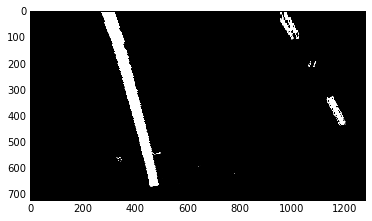

In [194]:
output = 'project_output_2.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(5,20)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))